# Testing playground for fine-tuning 

Run the following cell for importing libraries and the Oxford-IIIT Pet dataset. Replace `pretrained_weights_path` with the path with a valid pretrained encoder weight file (.pth).

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision.transforms as T
import torchvision

import time

from vit import ViT
from finetune import FineTune
from utils import OxfordIIITPetsAugmented, ToDevice, get_device

import matplotlib.pyplot as plt

# Path to the pre-trained weights
pretrained_weights_path = 'pretrained_encoder.pth'

# Set device
device = get_device()
print(f'Using device: {device}, {torch.cuda.get_device_name()}')

# Define some transformations for the Oxford IIIT Pet dataset
def tensor_trimap(t):
	x = t * 255
	x = x.to(torch.long)
	x = x - 1
	return x

def args_to_dict(**kwargs):
	return kwargs

transform_dict = args_to_dict(
	pre_transform=T.ToTensor(),
	pre_target_transform=T.ToTensor(),
	common_transform=T.Compose([
		ToDevice(get_device()),
		T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
		# Random Horizontal Flip as data augmentation.
		T.RandomHorizontalFlip(p=0.5),
	]),
	post_transform=T.Compose([
		# Color Jitter as data augmentation.
		T.ColorJitter(contrast=0.3),
	]),
	post_target_transform=T.Compose([
		T.Lambda(tensor_trimap),
	]),
)

# Download Oxford-IIIT Pet Dataset - train and test sets
trainset = OxfordIIITPetsAugmented(
	root='data',
	split="trainval",
	target_types="segmentation",
	download=True,
	**transform_dict,
)
testset = OxfordIIITPetsAugmented(
	root='data',
	split="test",
	target_types="segmentation",
	download=True,
	**transform_dict,
)

# load the data into ram
trainset, testset = list(trainset), list(testset)

trainloader = torch.utils.data.DataLoader(
		trainset,
		batch_size=64,
		shuffle=True,
)
		
		
testloader = torch.utils.data.DataLoader(
	testset,
	batch_size=64,
	shuffle=True,
)

# Instantiate encoder (ViT to be fine-tuned)
encoder = ViT(
    image_size = 128,
    patch_size = 16,
    num_classes = 2,
    dim = 768,
    depth = 12,
    heads = 12,
    mlp_dim = 3072,
).to(device)


# Print number of parameters
print('Number of parameters (encoder):', sum(p.numel() for p in encoder.parameters()))

# instantiate fine-tuning model, load weights from pre-trained model
model = FineTune(
    encoder = encoder,
    weights_path = pretrained_weights_path,
).to(device)

# Print number of parameters
print('Number of parameters (segmentation head):', 
		sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in encoder.parameters()))


Using device: cuda, NVIDIA GeForce GTX TITAN X
Number of parameters (encoder): 85674242
patch_size: 16
Number of parameters (segmentation head): 590592


In [ ]:
from finetune import FineTune
# Define optimizer and loss function for mlp head
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()

# Train
n_epochs = 1000
for epoch in range(n_epochs):
	epoch_start = time.time()
	j = 0 # Batch counter
	running_loss = 0.0 # for the epoch
	model.train() # Set model to training mode
	for i, data in enumerate(trainloader, 0):
		print(f'Batch {i + 1}/{len(trainloader)}  ', end='\r')
		inputs, labels = data
		inputs, labels = inputs.to(device), labels.to(device)

		optimizer.zero_grad()
		loss, _, _ = model(inputs, labels)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
		j += 1

	print(f'Epoch {epoch + 1}/{n_epochs} | Loss: {running_loss / j:.5f} | Time: {time.time() - epoch_start:.2f}s')
	
	torch.save(model.state_dict(), f'finetuned_weights.pth')
	model.display_example(testset, show=False, save=True)

# Save model
torch.save(model.state_dict(), 'finetuned_weights.pth')


 This one is for playing around with the fine-tuned model, after loading fine-tuned model weights. You first need to train the segmentation head by running main_finetune.py.

num_patches: 64 batch: 1


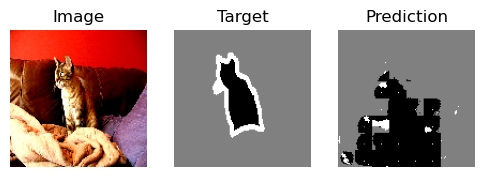

num_patches: 64 batch: 1


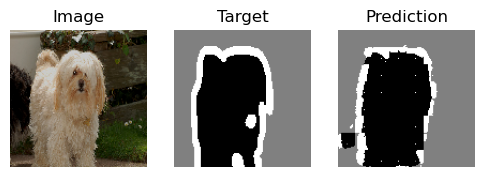

num_patches: 64 batch: 1


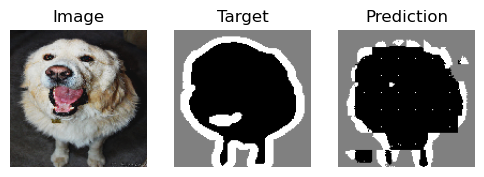

num_patches: 64 batch: 1


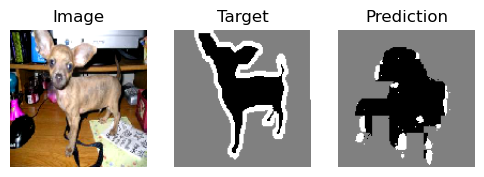

num_patches: 64 batch: 1


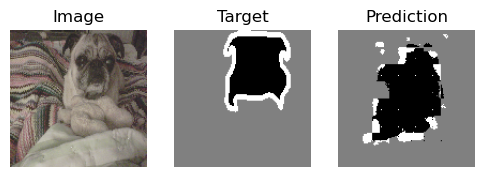

In [49]:
#load weights from fine-tuned model
model.load_state_dict(torch.load('finetuned_weights.pth'))

# Prediction mode
model.eval()


def display_example(testset, show=False, save=True):
	'''Display/save an example prediction from the segmentation model'''

	#pick image in test set
	idx = torch.randint(0, len(testset), (1,)).item()
	img, target = testset[idx]
	img = img.unsqueeze(0)
	target = target.unsqueeze(0)

	img_size = img.shape[-1]
	patch_size = 16
	num_patches = int((img_size//patch_size)**2)

	with torch.no_grad():
		_, pred_patches, target_patches = model(img, target)

	pred_patches = pred_patches[0]
	target_patches = target_patches[0]

	#make empty tensor to store full image
	pred_full = torch.zeros(1, img_size, img_size)
	target_full = torch.zeros(1, img_size, img_size)
	

	patch_i = 0
	for row in range(img_size//patch_size):
		for col in range(img_size//patch_size):
			target_plot = target_patches[patch_i].cpu().numpy()
			target_plot = target_plot.reshape(patch_size, patch_size)
			pred_plot = pred_patches[:,patch_i].cpu().numpy()
			pred_plot = pred_plot.reshape(3, patch_size, patch_size)
			
			#take argmax to plot
			pred_plot = pred_plot.argmax(axis=0)

			#add to full image
			target_full[0, row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = torch.tensor(target_plot)
			pred_full[0, row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = torch.tensor(pred_plot)
			patch_i += 1
			
	#plot targetand prediction
	fig, axs = plt.subplots(1, 3, figsize=(6, 2))
	axs[0].imshow(img[0].cpu().numpy().transpose(1, 2, 0))
	axs[0].set_title('Image')
	axs[1].imshow(target_full[0].cpu().numpy(), cmap='gray')
	axs[1].set_title('Target')
	axs[2].imshow(pred_full[0].cpu().numpy(), cmap='gray')
	axs[2].set_title('Prediction')

	for ax in axs:
		ax.axis('off')
	if save:
		plt.savefig('finetune_example.png')
	if show:
		plt.show()


for _ in range(5):
	display_example(testset, show=True, save=False)



patch_size: 16 encoder_dim: 768 num_patches: 65
num_patches: 64 batch: 1


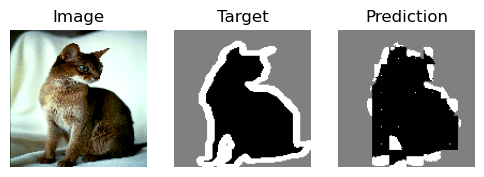

In [40]:
# Description: FineTune model class for training a Vision Transformer on a segmentation task.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt


class FineTune(nn.Module):
    """
    FineTune model class.
    -------------------
    Work in progress
    """
    def __init__(
        self,
        *,
        encoder,
        weights_path
    ):
        """
        Args:
            encoder (nn.Module): Vision Transformer to be trained.
            weights_path (str): Path to saved weights from pre-trained model.
        """
        super().__init__()

        # Instantiate encoder (ViT to be fine-tuned)
        self.encoder = encoder

        # Load weights from pre-trained model
        self.encoder.load_state_dict(torch.load(weights_path))

        # Freeze weights
        # for param in self.encoder.parameters():
        #     param.requires_grad = False

        # Get number of patches and encoder dimension
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.to_patch = encoder.to_patch_embedding[0]
        self.patch_to_emb = nn.Sequential(*encoder.to_patch_embedding[1:])
        pixel_values_per_patch = encoder.to_patch_embedding[2].weight.shape[-1]

        #infer patch size from above 
        self.patch_size = int((pixel_values_per_patch/3)**0.5)

        # Linear head (decoder) to predict segmentation target
        self.mlp = nn.Linear(encoder_dim, self.patch_size ** 2 * 3)

    def forward(self, img, target):
        """
        Run a forward pass of the FineTune model.

        Args:
            img (torch.Tensor): Input image tensor.
            target (torch.Tensor): Target segmentation tensor.

        Returns:
            loss (torch.Tensor): CrossEntropy loss.
            pred_patches (torch.Tensor,
                shape=(batch_size, 3, num_patches, patch_size, patch_size)):
                Predicted pixel values (one hot encoded) organised in patches.
            target_patches (torch.Tensor,
                shape=(batch_size, 3, num_patches, patch_size, patch_size)):
                Target pixel values (one hot encoded) organised in patches.
        """
        # Get device ('cuda' or 'cpu')
        device = img.device

        # Get patches
        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape
        print('num_patches:', num_patches, 'batch:', batch)
        

        # For indexing
        batch_range = torch.arange(batch, device = device)[:, None]

        # Get positions
        pos_emb = self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # Get embeddings
        tokens = self.patch_to_emb(patches)
        tokens = tokens + pos_emb

        # encoder output with weights frozen
        encoder_output = self.encoder.transformer(tokens)
        
        # pass each patch through the mlp
        mlp_output = self.mlp(encoder_output)
        mlp_output = mlp_output.reshape(batch, num_patches, 3, -1)
        mlp_output = mlp_output.permute(0, 2, 1, 3).reshape(batch, 3, -1)
        mlp_output = nn.functional.log_softmax(mlp_output, dim=-1)

        pred_patches = mlp_output.reshape(batch, 3, num_patches, self.patch_size, self.patch_size)
        
        # target to patches and one hot encode
        target_patches = self.to_patch(target)
        target_flat = target_patches.reshape(batch, -1)


        #calculate loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(mlp_output, target_flat)

        return loss, pred_patches, target_patches
    
    def display_example(self, testset, show=False, save=True):
        '''Display/save an example prediction from the segmentation model'''

        #pick image in test set
        idx = torch.randint(0, len(testset), (1,)).item()
        img, target = testset[idx]
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)

        img_size = img.shape[-1]
        patch_size = self.patch_size

        with torch.no_grad():
            _, pred_patches, target_patches = self.forward(img, target)

        pred_patches = pred_patches[0]
        target_patches = target_patches[0]

        #make empty tensor to store full image
        pred_full = torch.zeros(1, img_size, img_size)
        target_full = torch.zeros(1, img_size, img_size)

        patch_i = 0
        for row in range(img_size//patch_size):
            for col in range(img_size//patch_size):
                target_plot = target_patches[patch_i].cpu().numpy()
                target_plot = target_plot.reshape(patch_size, patch_size)
                pred_plot = pred_patches[:,patch_i].cpu().numpy()
                pred_plot = pred_plot.reshape(3, patch_size, patch_size)
                
                #take argmax to plot
                pred_plot = pred_plot.argmax(axis=0)

                #add to full image
                target_full[0, row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = torch.tensor(target_plot)
                pred_full[0, row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = torch.tensor(pred_plot)
                patch_i += 1
                
        #plot targetand prediction
        fig, axs = plt.subplots(1, 3, figsize=(6, 2))
        axs[0].imshow(img[0].cpu().numpy().transpose(1, 2, 0))
        axs[0].set_title('Image')
        axs[1].imshow(target_full[0].cpu().numpy(), cmap='gray')
        axs[1].set_title('Target')
        axs[2].imshow(pred_full[0].cpu().numpy(), cmap='gray')
        axs[2].set_title('Prediction')

        for ax in axs:
            ax.axis('off')
        if save:
            plt.savefig('finetune_example.png')
        if show:
            plt.show()
        plt.close()

# Instantiate encoder (ViT to be fine-tuned)
encoder = ViT(
	image_size = 128,
	patch_size = 16,
	num_classes = 2,
	dim = 768,
	depth = 12,
	heads = 12,
	mlp_dim = 3072,
).to(device)

#load pre-tuned weights
model = FineTune(
	encoder = encoder,
	weights_path = 'pretrained_encoder.pth',
).to(device)

#load fine-tuned weights
model.load_state_dict(torch.load('finetuned_weights.pth'))


# test model
model.display_example(testset, show=True, save=False)

